<a href="https://colab.research.google.com/github/ppiont/cnn-soc-wagga/blob/master/cnn_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-optimize

     |████████████████████████████████| 102kB 4.2MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Thesis/cnn-soc-wagga"

Mounted at /content/drive/
/content/drive/MyDrive/Thesis/cnn-soc-wagga


In [ ]:
# Standard lib imports
import os
import pathlib
import random

# Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from torch.utils.data import Dataset, DataLoader
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_convergence, plot_evaluations
import torch
import torch.nn as nn
import torch.optim as optim

# import torch.nn.functional as F
from torch.utils.data import DataLoader
import copy

# Custom imports
# from feat_eng.funcs import add_min, safe_log, get_corr_feats, min_max
from custom_metrics.metrics import mean_error, lin_ccc, model_efficiency_coefficient

In [ ]:
# ------------------- TO DO ------------------------------------------------- #

"""
Use Torch Dataset.. you made a class for it dummy
"""

# ------------------- Settings ---------------------------------------------- #


# Set matploblib style
plt.style.use('seaborn-colorblind')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.dpi'] = 450
plt.rcParams['savefig.transparent'] = True
plt.rcParams['savefig.format'] = 'svg'

# Reset params if needed
# plt.rcParams.update(mpl.rcParamsDefault)


# ------------------- Organization ------------------------------------------ #


DATA_DIR = pathlib.Path('data/')


def seed_everything(SEED=43):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.backends.cudnn.benchmark = False


SEED = 43
seed_everything(SEED=SEED)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
# ------------------- Read and prep data ------------------------------------ #


class Dataset(torch.utils.data.TensorDataset):
    """Characterize a PyTorch Dataset."""

    def __init__(self, features, targets):
        super().__init__()

        """Initialize with X and y."""
        self.features = torch.from_numpy(features).permute(0, 3, 1, 2)
        self.targets = torch.from_numpy(targets)

    def __len__(self):
        """Return total number of samples."""
        return len(self.targets)

    def __getitem__(self, idx):
        """Generate one data sample."""

        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.features[idx], self.targets[idx]


features = np.load("data/cnn_features.npy")
targets = np.load("data/cnn_targets.npy")[:, 0]


# Train-val-test split 7-2-1
x_train_, x_test, y_train_, y_test = train_test_split(features, targets, test_size=2 / 10)
x_train, x_val, y_train, y_val = train_test_split(x_train_, y_train_, test_size=2 / 8)

feature_reshaper = FunctionTransformer(
    func=np.reshape,
    inverse_func=np.reshape,
    kw_args={"newshape": (-1, 43)},
    inv_kw_args={"newshape": (-1, 15, 15, 43)},
)
feature_inverse_reshaper = FunctionTransformer(func=np.reshape, kw_args={"newshape": (-1, 15, 15, 43)})

target_reshaper = FunctionTransformer(func=np.reshape, kw_args={"newshape": (-1, 1)})

# Preprocessing
feature_transformer = Pipeline(
    steps=[
        ("reshaper", feature_reshaper),
        ("minmax_scaler", MinMaxScaler()),
        ("inverse_reshaper", feature_inverse_reshaper),
    ]
)
target_transformer = Pipeline(steps=[("reshaper", target_reshaper), ("minmax_scaler", MinMaxScaler())])

kfold_data = Dataset(feature_transformer.fit_transform(x_train_), target_transformer.fit_transform(y_train_))
train_data = Dataset(feature_transformer.fit_transform(x_train), target_transformer.fit_transform(y_train))
val_data = Dataset(feature_transformer.transform(x_val), target_transformer.transform(y_val))
test_data = Dataset(feature_transformer.transform(x_test), target_transformer.transform(y_test))

batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=4, pin_memory=False)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=4, pin_memory=False)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=4, pin_memory=False)

In [ ]:
# ------------------ CNN setup ---------------------------------------------- #


class CNN(nn.Module):
    """Neural Network class."""

    def __init__(self, conv1_channels=32, conv2_channels=64, linear1_neurons=64, linear2_neurons=32):
        """Initialize as subclass of nn.Module, inherit its methods."""
        super().__init__()

        self.conv1_channels = conv1_channels
        self.conv2_channels = conv2_channels
        self.linear1_neurons = linear1_neurons
        self.linear2_neurons = linear2_neurons

        self.conv1 = nn.Conv2d(43, self.conv1_channels, kernel_size=3, stride=3)  # stride i stedet for maxpool
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(self.conv1_channels)
        self.conv2 = nn.Conv2d(self.conv1_channels, self.conv2_channels, 3)
        self.bn2 = nn.BatchNorm2d(self.conv2_channels)
        self.flat = nn.Flatten()
        self.fc1 = nn.LazyLinear(self.linear1_neurons)
        self.bn3 = nn.BatchNorm1d(self.linear1_neurons)
        self.fc2 = nn.Linear(self.linear1_neurons, self.linear2_neurons)
        self.bn4 = nn.BatchNorm1d(self.linear2_neurons)
        self.out = nn.Linear(self.linear2_neurons, 1)


    def forward(self, x):

        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.fc2(x)
        x = self.bn4(x)
        x = self.out(x)

        return x  # prediction


def train_step(model, features, targets, optimizer, loss_fn):
    """Perform a single training step.

    Calulcates prediction, loss and gradients for a single batch
    and updates optimizer parameters accordingly."""

    # Set gradients to zero
    model.zero_grad()
    # Pass data through model
    output = model(features)
    # Calculate loss
    loss = loss_fn(output, targets)
    # Calculate gradients
    loss.backward()
    # Update parameters
    optimizer.step()

    return loss, output


def train_network(model, train_data, val_data, optimizer, loss_fn, n_epochs=2000, patience=100, print_progress=True):
    """Train a neural network model."""
    # Initalize loss as very high
    best_loss = 1e8

    # Create lists to hold train and val losses
    train_loss = []
    val_loss = []
    # Init epochs_no_improve
    epochs_no_improve = 0
    # best_model = copy.deepcopy(model.state_dict())

    # Start training (loop over epochs)
    for epoch in range(n_epochs):

        # Initalize epoch train loss
        train_epoch_loss = 0
        # Loop over training batches
        model.train()  # set model to training mode for training
        for bidx, (features, targets) in enumerate(train_data):
            # Calculate loss and predictions
            loss, predictions = train_step(model, features, targets, optimizer, loss_fn)
            train_epoch_loss += loss
        # Save train epoch loss
        train_loss.append(train_epoch_loss.item())

        # Initialize val epoch loss
        val_epoch_loss = 0
        # Loop over validation batches
        model.eval()  # set model to evaluation mode for validation
        for bidx, (features, targets) in enumerate(val_data):
            output = model(features)
            val_epoch_loss += loss_fn(output, targets)
        # Save val epoch loss
        val_loss.append(val_epoch_loss.item())

        # Early stopping (check if val loss is an improvement on current best)
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss.item()
            best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

            # Check early stopping condition
            if epochs_no_improve == patience:
                print(f"Stopping after {epoch} epochs due to no improvement.")
                model.load_state_dict(best_model)
                break
        # Print progress at set epoch intervals if desired
        if print_progress and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1} Train Loss: {train_epoch_loss:.4}, ", end="")
            print(f"Val Loss: {val_epoch_loss:.4}")

    return train_loss, val_loss


def weight_reset(m):
    """Reset all weights in an NN."""
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [ ]:
# ------------------- Cross-validation -------------------------------------- #


def kfold_cv_train(
    dataset,
    model,
    optimizer,
    loss_fn=nn.MSELoss(),
    n_splits=5,
    batch_size=128,
    n_epochs=2000,
    patience=100,
    shuffle=True,
    rng=SEED,
):
    """Train a NN with K-Fold cross-validation."""
    kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=rng)
    best_losses = []

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):

        # Print
        print(f"FOLD {fold}")
        print("--------------------------------")

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

        # Define data loaders for training and testing data in this fold
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

        # Train
        train_loss, val_loss = train_network(
            model=model,
            train_data=train_loader,
            val_data=val_loader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            n_epochs=n_epochs,
            patience=patience,
            print_progress=False,
        )
        best_losses.append(min(val_loss))
        model.apply(weight_reset)

    return sum(best_losses) / n_splits, train_loss, val_loss

Gaussian Process:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.
Stopping after 222 epochs due to no improvement.
Stopping after 450 epochs due to no improvement.
Stopping after 397 epochs due to no improvement.
Stopping after 590 epochs due to no improvement.


Gaussian Process:   1%|          | 1/100 [00:31<51:58, 31.50s/it]

Stopping after 574 epochs due to no improvement.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 31.4945
Function value obtained: 0.0151
Current minimum: 0.0151
Iteration No: 2 started. Evaluating function at random point.
Stopping after 273 epochs due to no improvement.
Stopping after 437 epochs due to no improvement.
Stopping after 322 epochs due to no improvement.
Stopping after 485 epochs due to no improvement.


Gaussian Process:   2%|▏         | 2/100 [01:01<50:35, 30.98s/it]

Stopping after 387 epochs due to no improvement.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 29.7528
Function value obtained: 0.0156
Current minimum: 0.0151
Iteration No: 3 started. Evaluating function at random point.
Stopping after 157 epochs due to no improvement.
Stopping after 380 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.
Stopping after 340 epochs due to no improvement.


Gaussian Process:   3%|▎         | 3/100 [01:25<46:59, 29.07s/it]

Stopping after 329 epochs due to no improvement.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 24.6105
Function value obtained: 0.0167
Current minimum: 0.0151
Iteration No: 4 started. Evaluating function at random point.
Stopping after 176 epochs due to no improvement.
Stopping after 553 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.
Stopping after 274 epochs due to no improvement.


Gaussian Process:   4%|▍         | 4/100 [01:54<46:05, 28.81s/it]

Stopping after 537 epochs due to no improvement.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 28.2026
Function value obtained: 0.0175
Current minimum: 0.0151
Iteration No: 5 started. Evaluating function at random point.
Stopping after 446 epochs due to no improvement.
Stopping after 580 epochs due to no improvement.
Stopping after 351 epochs due to no improvement.
Stopping after 433 epochs due to no improvement.


Gaussian Process:   5%|▌         | 5/100 [02:32<50:21, 31.80s/it]

Stopping after 570 epochs due to no improvement.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 38.7923
Function value obtained: 0.0163
Current minimum: 0.0151
Iteration No: 6 started. Evaluating function at random point.
Stopping after 240 epochs due to no improvement.
Stopping after 279 epochs due to no improvement.
Stopping after 300 epochs due to no improvement.
Stopping after 148 epochs due to no improvement.


Gaussian Process:   6%|▌         | 6/100 [02:51<43:50, 27.99s/it]

Stopping after 133 epochs due to no improvement.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 19.0794
Function value obtained: 0.0185
Current minimum: 0.0151
Iteration No: 7 started. Evaluating function at random point.
Stopping after 187 epochs due to no improvement.
Stopping after 393 epochs due to no improvement.
Stopping after 485 epochs due to no improvement.
Stopping after 272 epochs due to no improvement.


Gaussian Process:   7%|▋         | 7/100 [03:14<40:39, 26.23s/it]

Stopping after 244 epochs due to no improvement.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 22.1431
Function value obtained: 0.0163
Current minimum: 0.0151
Iteration No: 8 started. Evaluating function at random point.
Stopping after 247 epochs due to no improvement.
Stopping after 442 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.
Stopping after 402 epochs due to no improvement.


Gaussian Process:   8%|▊         | 8/100 [03:36<38:28, 25.09s/it]

Stopping after 203 epochs due to no improvement.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 22.4139
Function value obtained: 0.0165
Current minimum: 0.0151
Iteration No: 9 started. Evaluating function at random point.
Stopping after 247 epochs due to no improvement.
Stopping after 669 epochs due to no improvement.
Stopping after 242 epochs due to no improvement.
Stopping after 283 epochs due to no improvement.


Gaussian Process:   9%|▉         | 9/100 [04:05<39:53, 26.30s/it]

Stopping after 307 epochs due to no improvement.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 29.1388
Function value obtained: 0.0156
Current minimum: 0.0151
Iteration No: 10 started. Evaluating function at random point.
Stopping after 231 epochs due to no improvement.
Stopping after 133 epochs due to no improvement.
Stopping after 591 epochs due to no improvement.
Stopping after 418 epochs due to no improvement.


Gaussian Process:  10%|█         | 10/100 [04:32<39:47, 26.53s/it]

Stopping after 124 epochs due to no improvement.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 27.0454
Function value obtained: 0.0220
Current minimum: 0.0151
Iteration No: 11 started. Evaluating function at random point.
Stopping after 471 epochs due to no improvement.
Stopping after 473 epochs due to no improvement.
Stopping after 290 epochs due to no improvement.
Stopping after 354 epochs due to no improvement.


Gaussian Process:  11%|█         | 11/100 [05:06<42:42, 28.79s/it]

Stopping after 483 epochs due to no improvement.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 34.0656
Function value obtained: 0.0158
Current minimum: 0.0151
Iteration No: 12 started. Evaluating function at random point.
Stopping after 281 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.
Stopping after 267 epochs due to no improvement.
Stopping after 494 epochs due to no improvement.


Gaussian Process:  12%|█▏        | 12/100 [05:28<39:04, 26.64s/it]

Stopping after 296 epochs due to no improvement.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 21.6379
Function value obtained: 0.0153
Current minimum: 0.0151
Iteration No: 13 started. Evaluating function at random point.
Stopping after 291 epochs due to no improvement.
Stopping after 494 epochs due to no improvement.
Stopping after 385 epochs due to no improvement.
Stopping after 453 epochs due to no improvement.


Gaussian Process:  13%|█▎        | 13/100 [06:05<43:15, 29.84s/it]

Stopping after 528 epochs due to no improvement.
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 37.2919
Function value obtained: 0.0183
Current minimum: 0.0151
Iteration No: 14 started. Evaluating function at random point.
Stopping after 179 epochs due to no improvement.
Stopping after 556 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 234 epochs due to no improvement.


Gaussian Process:  14%|█▍        | 14/100 [06:28<39:55, 27.85s/it]

Stopping after 219 epochs due to no improvement.
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 23.2210
Function value obtained: 0.0210
Current minimum: 0.0151
Iteration No: 15 started. Evaluating function at random point.
Stopping after 177 epochs due to no improvement.
Stopping after 204 epochs due to no improvement.
Stopping after 188 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.


Gaussian Process:  15%|█▌        | 15/100 [06:46<35:02, 24.74s/it]

Stopping after 221 epochs due to no improvement.
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 17.4639
Function value obtained: 0.0186
Current minimum: 0.0151
Iteration No: 16 started. Evaluating function at random point.
Stopping after 241 epochs due to no improvement.
Stopping after 317 epochs due to no improvement.
Stopping after 287 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.


Gaussian Process:  16%|█▌        | 16/100 [07:03<31:29, 22.50s/it]

Stopping after 212 epochs due to no improvement.
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 17.2777
Function value obtained: 0.0176
Current minimum: 0.0151
Iteration No: 17 started. Evaluating function at random point.
Stopping after 219 epochs due to no improvement.
Stopping after 390 epochs due to no improvement.
Stopping after 409 epochs due to no improvement.
Stopping after 368 epochs due to no improvement.


Gaussian Process:  17%|█▋        | 17/100 [07:33<34:20, 24.82s/it]

Stopping after 351 epochs due to no improvement.
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 30.2489
Function value obtained: 0.0164
Current minimum: 0.0151
Iteration No: 18 started. Evaluating function at random point.
Stopping after 418 epochs due to no improvement.
Stopping after 466 epochs due to no improvement.
Stopping after 366 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.


Gaussian Process:  18%|█▊        | 18/100 [08:10<38:57, 28.50s/it]

Stopping after 657 epochs due to no improvement.
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 37.0801
Function value obtained: 0.0159
Current minimum: 0.0151
Iteration No: 19 started. Evaluating function at random point.
Stopping after 100 epochs due to no improvement.
Stopping after 604 epochs due to no improvement.
Stopping after 138 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.


Gaussian Process:  19%|█▉        | 19/100 [08:28<34:08, 25.29s/it]

Stopping after 101 epochs due to no improvement.
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 17.7828
Function value obtained: 0.0225
Current minimum: 0.0151
Iteration No: 20 started. Evaluating function at random point.
Stopping after 372 epochs due to no improvement.
Stopping after 386 epochs due to no improvement.
Stopping after 564 epochs due to no improvement.
Stopping after 343 epochs due to no improvement.
Stopping after 610 epochs due to no improvement.


Gaussian Process:  20%|██        | 20/100 [09:05<38:09, 28.61s/it]

Iteration No: 20 ended. Evaluation done at random point.
Time taken: 36.3760
Function value obtained: 0.0152
Current minimum: 0.0151
Iteration No: 21 started. Searching for the next optimal point.
Stopping after 156 epochs due to no improvement.
Stopping after 187 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.
Stopping after 227 epochs due to no improvement.
Stopping after 185 epochs due to no improvement.


Gaussian Process:  21%|██        | 21/100 [09:19<32:07, 24.39s/it]

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 14.5499
Function value obtained: 0.0155
Current minimum: 0.0151
Iteration No: 22 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.


Gaussian Process:  22%|██▏       | 22/100 [09:54<35:42, 27.46s/it]

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 34.6211
Function value obtained: 0.1984
Current minimum: 0.0151
Iteration No: 23 started. Searching for the next optimal point.
Stopping after 334 epochs due to no improvement.
Stopping after 611 epochs due to no improvement.
Stopping after 255 epochs due to no improvement.
Stopping after 248 epochs due to no improvement.
Stopping after 1057 epochs due to no improvement.


Gaussian Process:  23%|██▎       | 23/100 [10:38<41:39, 32.46s/it]

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 44.1100
Function value obtained: 0.0886
Current minimum: 0.0151
Iteration No: 24 started. Searching for the next optimal point.
Stopping after 334 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1008 epochs due to no improvement.


Gaussian Process:  24%|██▍       | 24/100 [11:03<38:14, 30.19s/it]

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 24.8952
Function value obtained: 0.0707
Current minimum: 0.0151
Iteration No: 25 started. Searching for the next optimal point.
Stopping after 1823 epochs due to no improvement.
Stopping after 1283 epochs due to no improvement.
Stopping after 690 epochs due to no improvement.
Stopping after 667 epochs due to no improvement.


Gaussian Process:  25%|██▌       | 25/100 [12:56<1:08:46, 55.03s/it]

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 112.9802
Function value obtained: 0.0693
Current minimum: 0.0151
Iteration No: 26 started. Searching for the next optimal point.
Stopping after 216 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.
Stopping after 136 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.


Gaussian Process:  26%|██▌       | 26/100 [13:08<52:10, 42.30s/it]  

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 12.6002
Function value obtained: 0.0242
Current minimum: 0.0151
Iteration No: 27 started. Searching for the next optimal point.
Stopping after 235 epochs due to no improvement.
Stopping after 222 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 293 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.


Gaussian Process:  27%|██▋       | 27/100 [13:22<41:01, 33.73s/it]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 13.7221
Function value obtained: 0.0229
Current minimum: 0.0151
Iteration No: 28 started. Searching for the next optimal point.
Stopping after 115 epochs due to no improvement.
Stopping after 185 epochs due to no improvement.
Stopping after 186 epochs due to no improvement.
Stopping after 193 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.


Gaussian Process:  28%|██▊       | 28/100 [13:34<32:29, 27.07s/it]

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 11.5470
Function value obtained: 0.0155
Current minimum: 0.0151
Iteration No: 29 started. Searching for the next optimal point.
Stopping after 256 epochs due to no improvement.
Stopping after 418 epochs due to no improvement.
Stopping after 555 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 266 epochs due to no improvement.


Gaussian Process:  29%|██▉       | 29/100 [13:56<30:26, 25.73s/it]

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 22.5934
Function value obtained: 0.2639
Current minimum: 0.0151
Iteration No: 30 started. Searching for the next optimal point.
Stopping after 230 epochs due to no improvement.
Stopping after 526 epochs due to no improvement.
Stopping after 435 epochs due to no improvement.
Stopping after 414 epochs due to no improvement.
Stopping after 250 epochs due to no improvement.


Gaussian Process:  30%|███       | 30/100 [14:23<30:31, 26.17s/it]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 27.1930
Function value obtained: 0.0154
Current minimum: 0.0151
Iteration No: 31 started. Searching for the next optimal point.
Stopping after 409 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 488 epochs due to no improvement.
Stopping after 539 epochs due to no improvement.
Stopping after 366 epochs due to no improvement.


Gaussian Process:  31%|███       | 31/100 [14:57<32:40, 28.42s/it]

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 33.6687
Function value obtained: 0.0171
Current minimum: 0.0151
Iteration No: 32 started. Searching for the next optimal point.
Stopping after 136 epochs due to no improvement.
Stopping after 158 epochs due to no improvement.
Stopping after 167 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 174 epochs due to no improvement.


Gaussian Process:  32%|███▏      | 32/100 [15:11<27:16, 24.06s/it]

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 13.8969
Function value obtained: 0.0242
Current minimum: 0.0151
Iteration No: 33 started. Searching for the next optimal point.
Stopping after 226 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 337 epochs due to no improvement.
Stopping after 431 epochs due to no improvement.


Gaussian Process:  33%|███▎      | 33/100 [15:33<26:13, 23.48s/it]

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 22.1262
Function value obtained: 0.0169
Current minimum: 0.0151
Iteration No: 34 started. Searching for the next optimal point.
Stopping after 107 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1227 epochs due to no improvement.


Gaussian Process:  34%|███▍      | 34/100 [16:23<34:38, 31.49s/it]

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 50.1672
Function value obtained: 0.0821
Current minimum: 0.0151
Iteration No: 35 started. Searching for the next optimal point.
Stopping after 197 epochs due to no improvement.
Stopping after 156 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.
Stopping after 156 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.


Gaussian Process:  35%|███▌      | 35/100 [16:36<28:04, 25.92s/it]

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 12.9207
Function value obtained: 0.0156
Current minimum: 0.0151
Iteration No: 36 started. Searching for the next optimal point.
Stopping after 245 epochs due to no improvement.
Stopping after 165 epochs due to no improvement.
Stopping after 292 epochs due to no improvement.
Stopping after 211 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.


Gaussian Process:  36%|███▌      | 36/100 [16:53<24:51, 23.31s/it]

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 17.2303
Function value obtained: 0.2407
Current minimum: 0.0151
Iteration No: 37 started. Searching for the next optimal point.
Stopping after 117 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1738 epochs due to no improvement.
Stopping after 845 epochs due to no improvement.
Stopping after 1835 epochs due to no improvement.


Gaussian Process:  37%|███▋      | 37/100 [17:59<37:55, 36.11s/it]

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 65.9807
Function value obtained: 0.0566
Current minimum: 0.0151
Iteration No: 38 started. Searching for the next optimal point.
Stopping after 209 epochs due to no improvement.
Stopping after 306 epochs due to no improvement.
Stopping after 361 epochs due to no improvement.
Stopping after 293 epochs due to no improvement.
Stopping after 473 epochs due to no improvement.


Gaussian Process:  38%|███▊      | 38/100 [18:29<35:18, 34.17s/it]

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 29.6436
Function value obtained: 0.0162
Current minimum: 0.0151
Iteration No: 39 started. Searching for the next optimal point.
Stopping after 1139 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 692 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.
Stopping after 543 epochs due to no improvement.


Gaussian Process:  39%|███▉      | 39/100 [19:16<38:34, 37.94s/it]

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 46.7454
Function value obtained: 0.1263
Current minimum: 0.0151
Iteration No: 40 started. Searching for the next optimal point.
Stopping after 172 epochs due to no improvement.
Stopping after 377 epochs due to no improvement.
Stopping after 237 epochs due to no improvement.
Stopping after 551 epochs due to no improvement.
Stopping after 515 epochs due to no improvement.


Gaussian Process:  40%|████      | 40/100 [19:47<35:45, 35.77s/it]

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 30.6844
Function value obtained: 0.0159
Current minimum: 0.0151
Iteration No: 41 started. Searching for the next optimal point.
Stopping after 157 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.
Stopping after 237 epochs due to no improvement.
Stopping after 138 epochs due to no improvement.
Stopping after 230 epochs due to no improvement.


Gaussian Process:  41%|████      | 41/100 [20:02<29:13, 29.72s/it]

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 15.6146
Function value obtained: 0.0157
Current minimum: 0.0151
Iteration No: 42 started. Searching for the next optimal point.
Stopping after 347 epochs due to no improvement.
Stopping after 435 epochs due to no improvement.
Stopping after 129 epochs due to no improvement.
Stopping after 306 epochs due to no improvement.
Stopping after 444 epochs due to no improvement.


Gaussian Process:  42%|████▏     | 42/100 [20:30<28:14, 29.21s/it]

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 28.0345
Function value obtained: 0.0186
Current minimum: 0.0151
Iteration No: 43 started. Searching for the next optimal point.
Stopping after 104 epochs due to no improvement.
Stopping after 171 epochs due to no improvement.
Stopping after 185 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 141 epochs due to no improvement.


Gaussian Process:  43%|████▎     | 43/100 [20:44<23:18, 24.54s/it]

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 13.6334
Function value obtained: 0.0242
Current minimum: 0.0151
Iteration No: 44 started. Searching for the next optimal point.
Stopping after 147 epochs due to no improvement.
Stopping after 349 epochs due to no improvement.
Stopping after 389 epochs due to no improvement.
Stopping after 387 epochs due to no improvement.
Stopping after 378 epochs due to no improvement.


Gaussian Process:  44%|████▍     | 44/100 [21:11<23:47, 25.48s/it]

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 27.6832
Function value obtained: 0.0162
Current minimum: 0.0151
Iteration No: 45 started. Searching for the next optimal point.
Stopping after 190 epochs due to no improvement.
Stopping after 145 epochs due to no improvement.
Stopping after 323 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.
Stopping after 319 epochs due to no improvement.


Gaussian Process:  45%|████▌     | 45/100 [21:31<21:47, 23.77s/it]

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 19.7763
Function value obtained: 0.0194
Current minimum: 0.0151
Iteration No: 46 started. Searching for the next optimal point.
Stopping after 297 epochs due to no improvement.
Stopping after 314 epochs due to no improvement.
Stopping after 344 epochs due to no improvement.
Stopping after 213 epochs due to no improvement.
Stopping after 203 epochs due to no improvement.


Gaussian Process:  46%|████▌     | 46/100 [21:54<21:10, 23.52s/it]

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 22.9356
Function value obtained: 0.0172
Current minimum: 0.0151
Iteration No: 47 started. Searching for the next optimal point.
Stopping after 179 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.
Stopping after 161 epochs due to no improvement.
Stopping after 162 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.


Gaussian Process:  47%|████▋     | 47/100 [22:07<17:49, 20.19s/it]

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 12.4093
Function value obtained: 0.0160
Current minimum: 0.0151
Iteration No: 48 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 130 epochs due to no improvement.
Stopping after 164 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.


Gaussian Process:  48%|████▊     | 48/100 [22:18<15:11, 17.54s/it]

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 11.3479
Function value obtained: 0.0243
Current minimum: 0.0151
Iteration No: 49 started. Searching for the next optimal point.
Stopping after 411 epochs due to no improvement.
Stopping after 356 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.
Stopping after 298 epochs due to no improvement.


Gaussian Process:  49%|████▉     | 49/100 [22:40<16:09, 19.01s/it]

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 22.4410
Function value obtained: 0.0179
Current minimum: 0.0151
Iteration No: 50 started. Searching for the next optimal point.
Stopping after 336 epochs due to no improvement.
Stopping after 495 epochs due to no improvement.
Stopping after 130 epochs due to no improvement.
Stopping after 464 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.


Gaussian Process:  50%|█████     | 50/100 [23:06<17:28, 20.98s/it]

Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 25.5673
Function value obtained: 0.0172
Current minimum: 0.0151
Iteration No: 51 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 327 epochs due to no improvement.


Gaussian Process:  51%|█████     | 51/100 [23:20<15:30, 18.99s/it]

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 14.3637
Function value obtained: 0.0245
Current minimum: 0.0151
Iteration No: 52 started. Searching for the next optimal point.
Stopping after 112 epochs due to no improvement.
Stopping after 300 epochs due to no improvement.
Stopping after 213 epochs due to no improvement.
Stopping after 242 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.


Gaussian Process:  52%|█████▏    | 52/100 [23:38<14:57, 18.70s/it]

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 18.0100
Function value obtained: 0.0242
Current minimum: 0.0151
Iteration No: 53 started. Searching for the next optimal point.
Stopping after 198 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.
Stopping after 301 epochs due to no improvement.
Stopping after 370 epochs due to no improvement.


Gaussian Process:  53%|█████▎    | 53/100 [24:00<15:26, 19.72s/it]

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 22.1084
Function value obtained: 0.0231
Current minimum: 0.0151
Iteration No: 54 started. Searching for the next optimal point.
Stopping after 155 epochs due to no improvement.
Stopping after 628 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.
Stopping after 445 epochs due to no improvement.
Stopping after 519 epochs due to no improvement.


Gaussian Process:  54%|█████▍    | 54/100 [24:29<17:15, 22.51s/it]

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 29.0039
Function value obtained: 0.0165
Current minimum: 0.0151
Iteration No: 55 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 226 epochs due to no improvement.
Stopping after 147 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 261 epochs due to no improvement.


Gaussian Process:  55%|█████▌    | 55/100 [24:45<15:21, 20.47s/it]

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 15.7137
Function value obtained: 0.0242
Current minimum: 0.0151
Iteration No: 56 started. Searching for the next optimal point.
Stopping after 1690 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:  56%|█████▌    | 56/100 [25:24<19:05, 26.03s/it]

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 39.0124
Function value obtained: 0.1931
Current minimum: 0.0151
Iteration No: 57 started. Searching for the next optimal point.
Stopping after 316 epochs due to no improvement.
Stopping after 266 epochs due to no improvement.
Stopping after 232 epochs due to no improvement.
Stopping after 195 epochs due to no improvement.
Stopping after 196 epochs due to no improvement.


Gaussian Process:  57%|█████▋    | 57/100 [25:42<16:55, 23.61s/it]

Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 17.9618
Function value obtained: 0.0199
Current minimum: 0.0151
Iteration No: 58 started. Searching for the next optimal point.
Stopping after 114 epochs due to no improvement.
Stopping after 250 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.
Stopping after 207 epochs due to no improvement.
Stopping after 207 epochs due to no improvement.


Gaussian Process:  58%|█████▊    | 58/100 [25:58<14:49, 21.17s/it]

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 15.4768
Function value obtained: 0.0154
Current minimum: 0.0151
Iteration No: 59 started. Searching for the next optimal point.
Stopping after 151 epochs due to no improvement.
Stopping after 336 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 170 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.


Gaussian Process:  59%|█████▉    | 59/100 [26:17<14:01, 20.52s/it]

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 18.9926
Function value obtained: 0.0192
Current minimum: 0.0151
Iteration No: 60 started. Searching for the next optimal point.
Stopping after 397 epochs due to no improvement.
Stopping after 361 epochs due to no improvement.
Stopping after 423 epochs due to no improvement.
Stopping after 370 epochs due to no improvement.
Stopping after 491 epochs due to no improvement.


Gaussian Process:  60%|██████    | 60/100 [26:47<15:42, 23.55s/it]

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 30.6395
Function value obtained: 0.0146
Current minimum: 0.0146
Iteration No: 61 started. Searching for the next optimal point.
Stopping after 348 epochs due to no improvement.
Stopping after 259 epochs due to no improvement.
Stopping after 331 epochs due to no improvement.
Stopping after 270 epochs due to no improvement.
Stopping after 211 epochs due to no improvement.


Gaussian Process:  61%|██████    | 61/100 [27:09<14:52, 22.88s/it]

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 21.2932
Function value obtained: 0.0147
Current minimum: 0.0146
Iteration No: 62 started. Searching for the next optimal point.
Stopping after 138 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 482 epochs due to no improvement.
Stopping after 352 epochs due to no improvement.
Stopping after 254 epochs due to no improvement.


Gaussian Process:  62%|██████▏   | 62/100 [27:33<14:49, 23.41s/it]

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 24.6699
Function value obtained: 0.0221
Current minimum: 0.0146
Iteration No: 63 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.
Stopping after 129 epochs due to no improvement.
Stopping after 148 epochs due to no improvement.


Gaussian Process:  63%|██████▎   | 63/100 [27:45<12:18, 19.95s/it]

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 11.8597
Function value obtained: 0.0242
Current minimum: 0.0146
Iteration No: 64 started. Searching for the next optimal point.
Stopping after 255 epochs due to no improvement.
Stopping after 601 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.
Stopping after 492 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.


Gaussian Process:  64%|██████▍   | 64/100 [28:15<13:40, 22.80s/it]

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 29.4574
Function value obtained: 0.0178
Current minimum: 0.0146
Iteration No: 65 started. Searching for the next optimal point.
Stopping after 170 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.
Stopping after 242 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.
Stopping after 255 epochs due to no improvement.


Gaussian Process:  65%|██████▌   | 65/100 [28:35<12:52, 22.06s/it]

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 20.3478
Function value obtained: 0.0194
Current minimum: 0.0146
Iteration No: 66 started. Searching for the next optimal point.
Stopping after 547 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.
Stopping after 733 epochs due to no improvement.
Stopping after 418 epochs due to no improvement.
Stopping after 465 epochs due to no improvement.


Gaussian Process:  66%|██████▌   | 66/100 [29:10<14:47, 26.11s/it]

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 35.5579
Function value obtained: 0.0144
Current minimum: 0.0144
Iteration No: 67 started. Searching for the next optimal point.
Stopping after 309 epochs due to no improvement.
Stopping after 233 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 141 epochs due to no improvement.
Stopping after 321 epochs due to no improvement.


Gaussian Process:  67%|██████▋   | 67/100 [29:29<13:11, 23.98s/it]

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 19.0200
Function value obtained: 0.0215
Current minimum: 0.0144
Iteration No: 68 started. Searching for the next optimal point.
Stopping after 235 epochs due to no improvement.
Stopping after 366 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 639 epochs due to no improvement.


Gaussian Process:  68%|██████▊   | 68/100 [29:56<13:08, 24.64s/it]

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 26.1650
Function value obtained: 0.0150
Current minimum: 0.0144
Iteration No: 69 started. Searching for the next optimal point.
Stopping after 112 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.
Stopping after 162 epochs due to no improvement.
Stopping after 167 epochs due to no improvement.
Stopping after 159 epochs due to no improvement.


Gaussian Process:  69%|██████▉   | 69/100 [30:10<11:05, 21.45s/it]

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 14.0251
Function value obtained: 0.0221
Current minimum: 0.0144
Iteration No: 70 started. Searching for the next optimal point.
Stopping after 312 epochs due to no improvement.
Stopping after 381 epochs due to no improvement.
Stopping after 204 epochs due to no improvement.
Stopping after 274 epochs due to no improvement.
Stopping after 325 epochs due to no improvement.


Gaussian Process:  70%|███████   | 70/100 [30:32<10:52, 21.76s/it]

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 22.4718
Function value obtained: 0.0207
Current minimum: 0.0144
Iteration No: 71 started. Searching for the next optimal point.
Stopping after 338 epochs due to no improvement.
Stopping after 576 epochs due to no improvement.
Stopping after 594 epochs due to no improvement.
Stopping after 401 epochs due to no improvement.
Stopping after 274 epochs due to no improvement.


Gaussian Process:  71%|███████   | 71/100 [31:12<13:13, 27.35s/it]

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 40.3886
Function value obtained: 0.0166
Current minimum: 0.0144
Iteration No: 72 started. Searching for the next optimal point.
Stopping after 475 epochs due to no improvement.
Stopping after 577 epochs due to no improvement.
Stopping after 349 epochs due to no improvement.
Stopping after 503 epochs due to no improvement.
Stopping after 318 epochs due to no improvement.


Gaussian Process:  72%|███████▏  | 72/100 [31:54<14:42, 31.51s/it]

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 41.2066
Function value obtained: 0.0161
Current minimum: 0.0144
Iteration No: 73 started. Searching for the next optimal point.
Stopping after 247 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.
Stopping after 238 epochs due to no improvement.
Stopping after 252 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.


Gaussian Process:  73%|███████▎  | 73/100 [32:11<12:18, 27.34s/it]

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 17.6293
Function value obtained: 0.0153
Current minimum: 0.0144
Iteration No: 74 started. Searching for the next optimal point.
Stopping after 184 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.


Gaussian Process:  74%|███████▍  | 74/100 [32:29<10:32, 24.32s/it]

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 17.2508
Function value obtained: 0.0155
Current minimum: 0.0144
Iteration No: 75 started. Searching for the next optimal point.
Stopping after 426 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 505 epochs due to no improvement.
Stopping after 514 epochs due to no improvement.
Stopping after 251 epochs due to no improvement.


Gaussian Process:  75%|███████▌  | 75/100 [33:02<11:16, 27.04s/it]

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 33.4049
Function value obtained: 0.0737
Current minimum: 0.0144
Iteration No: 76 started. Searching for the next optimal point.
Stopping after 445 epochs due to no improvement.
Stopping after 1114 epochs due to no improvement.
Stopping after 582 epochs due to no improvement.
Stopping after 1165 epochs due to no improvement.


Gaussian Process:  76%|███████▌  | 76/100 [34:30<18:11, 45.47s/it]

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 88.4839
Function value obtained: 0.0530
Current minimum: 0.0144
Iteration No: 77 started. Searching for the next optimal point.
Stopping after 108 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 286 epochs due to no improvement.
Stopping after 130 epochs due to no improvement.


Gaussian Process:  77%|███████▋  | 77/100 [34:44<13:44, 35.83s/it]

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 13.3303
Function value obtained: 0.0245
Current minimum: 0.0144
Iteration No: 78 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 309 epochs due to no improvement.
Stopping after 251 epochs due to no improvement.
Stopping after 298 epochs due to no improvement.
Stopping after 266 epochs due to no improvement.


Gaussian Process:  78%|███████▊  | 78/100 [35:05<11:34, 31.57s/it]

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 21.6257
Function value obtained: 0.0225
Current minimum: 0.0144
Iteration No: 79 started. Searching for the next optimal point.
Stopping after 298 epochs due to no improvement.
Stopping after 263 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 418 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.


Gaussian Process:  79%|███████▉  | 79/100 [35:26<09:54, 28.32s/it]

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 20.7446
Function value obtained: 0.2489
Current minimum: 0.0144
Iteration No: 80 started. Searching for the next optimal point.
Stopping after 199 epochs due to no improvement.
Stopping after 400 epochs due to no improvement.
Stopping after 250 epochs due to no improvement.
Stopping after 198 epochs due to no improvement.
Stopping after 337 epochs due to no improvement.


Gaussian Process:  80%|████████  | 80/100 [35:47<08:42, 26.15s/it]

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 21.0711
Function value obtained: 0.0201
Current minimum: 0.0144
Iteration No: 81 started. Searching for the next optimal point.
Stopping after 229 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.
Stopping after 399 epochs due to no improvement.
Stopping after 405 epochs due to no improvement.
Stopping after 312 epochs due to no improvement.


Gaussian Process:  81%|████████  | 81/100 [36:14<08:21, 26.41s/it]

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 27.0346
Function value obtained: 0.0164
Current minimum: 0.0144
Iteration No: 82 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 228 epochs due to no improvement.
Stopping after 325 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 310 epochs due to no improvement.


Gaussian Process:  82%|████████▏ | 82/100 [36:35<07:24, 24.71s/it]

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 20.7287
Function value obtained: 0.0243
Current minimum: 0.0144
Iteration No: 83 started. Searching for the next optimal point.
Stopping after 167 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 391 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.
Stopping after 139 epochs due to no improvement.


Gaussian Process:  83%|████████▎ | 83/100 [36:53<06:24, 22.63s/it]

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 17.7828
Function value obtained: 0.0235
Current minimum: 0.0144
Iteration No: 84 started. Searching for the next optimal point.
Stopping after 260 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.
Stopping after 398 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.
Stopping after 244 epochs due to no improvement.


Gaussian Process:  84%|████████▍ | 84/100 [37:15<05:58, 22.38s/it]

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 21.8092
Function value obtained: 0.0210
Current minimum: 0.0144
Iteration No: 85 started. Searching for the next optimal point.
Stopping after 245 epochs due to no improvement.
Stopping after 276 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.
Stopping after 239 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.


Gaussian Process:  85%|████████▌ | 85/100 [37:34<05:21, 21.44s/it]

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 19.2448
Function value obtained: 0.0198
Current minimum: 0.0144
Iteration No: 86 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1362 epochs due to no improvement.
Stopping after 1658 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.


Gaussian Process:  86%|████████▌ | 86/100 [38:22<06:51, 29.42s/it]

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 48.0293
Function value obtained: 0.0569
Current minimum: 0.0144
Iteration No: 87 started. Searching for the next optimal point.
Stopping after 206 epochs due to no improvement.
Stopping after 220 epochs due to no improvement.
Stopping after 201 epochs due to no improvement.
Stopping after 227 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.


Gaussian Process:  87%|████████▋ | 87/100 [38:39<05:32, 25.58s/it]

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 16.6270
Function value obtained: 0.0153
Current minimum: 0.0144
Iteration No: 88 started. Searching for the next optimal point.
Stopping after 252 epochs due to no improvement.
Stopping after 320 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.
Stopping after 226 epochs due to no improvement.
Stopping after 195 epochs due to no improvement.


Gaussian Process:  88%|████████▊ | 88/100 [39:00<04:53, 24.44s/it]

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 21.7920
Function value obtained: 0.0188
Current minimum: 0.0144
Iteration No: 89 started. Searching for the next optimal point.
Stopping after 109 epochs due to no improvement.
Stopping after 401 epochs due to no improvement.
Stopping after 350 epochs due to no improvement.
Stopping after 362 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.


Gaussian Process:  89%|████████▉ | 89/100 [39:25<04:29, 24.54s/it]

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 24.7565
Function value obtained: 0.2604
Current minimum: 0.0144
Iteration No: 90 started. Searching for the next optimal point.
Stopping after 278 epochs due to no improvement.
Stopping after 273 epochs due to no improvement.
Stopping after 316 epochs due to no improvement.
Stopping after 583 epochs due to no improvement.
Stopping after 254 epochs due to no improvement.


Gaussian Process:  90%|█████████ | 90/100 [39:51<04:09, 24.94s/it]

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 25.8773
Function value obtained: 0.0151
Current minimum: 0.0144
Iteration No: 91 started. Searching for the next optimal point.
Stopping after 426 epochs due to no improvement.
Stopping after 541 epochs due to no improvement.
Stopping after 447 epochs due to no improvement.
Stopping after 418 epochs due to no improvement.
Stopping after 280 epochs due to no improvement.


Gaussian Process:  91%|█████████ | 91/100 [40:23<04:03, 27.07s/it]

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 32.0365
Function value obtained: 0.0157
Current minimum: 0.0144
Iteration No: 92 started. Searching for the next optimal point.
Stopping after 266 epochs due to no improvement.
Stopping after 505 epochs due to no improvement.
Stopping after 327 epochs due to no improvement.
Stopping after 320 epochs due to no improvement.
Stopping after 724 epochs due to no improvement.


Gaussian Process:  92%|█████████▏| 92/100 [40:55<03:49, 28.64s/it]

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 32.3136
Function value obtained: 0.0152
Current minimum: 0.0144
Iteration No: 93 started. Searching for the next optimal point.
Stopping after 183 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.
Stopping after 186 epochs due to no improvement.
Stopping after 613 epochs due to no improvement.
Stopping after 216 epochs due to no improvement.


Gaussian Process:  93%|█████████▎| 93/100 [41:18<03:07, 26.73s/it]

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 22.2837
Function value obtained: 0.0156
Current minimum: 0.0144
Iteration No: 94 started. Searching for the next optimal point.
Stopping after 151 epochs due to no improvement.
Stopping after 251 epochs due to no improvement.
Stopping after 337 epochs due to no improvement.
Stopping after 337 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.


Gaussian Process:  94%|█████████▍| 94/100 [41:38<02:29, 24.90s/it]

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 20.6286
Function value obtained: 0.0159
Current minimum: 0.0144
Iteration No: 95 started. Searching for the next optimal point.
Stopping after 201 epochs due to no improvement.
Stopping after 387 epochs due to no improvement.
Stopping after 180 epochs due to no improvement.
Stopping after 246 epochs due to no improvement.
Stopping after 456 epochs due to no improvement.


Gaussian Process:  95%|█████████▌| 95/100 [42:01<02:01, 24.25s/it]

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 22.7236
Function value obtained: 0.0154
Current minimum: 0.0144
Iteration No: 96 started. Searching for the next optimal point.
Stopping after 325 epochs due to no improvement.
Stopping after 288 epochs due to no improvement.
Stopping after 283 epochs due to no improvement.
Stopping after 211 epochs due to no improvement.
Stopping after 410 epochs due to no improvement.


Gaussian Process:  96%|█████████▌| 96/100 [42:24<01:35, 23.99s/it]

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 23.3702
Function value obtained: 0.0152
Current minimum: 0.0144
Iteration No: 97 started. Searching for the next optimal point.
Stopping after 158 epochs due to no improvement.
Stopping after 477 epochs due to no improvement.
Stopping after 364 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.


Gaussian Process:  97%|█████████▋| 97/100 [42:48<01:11, 23.93s/it]

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 23.8016
Function value obtained: 0.0152
Current minimum: 0.0144
Iteration No: 98 started. Searching for the next optimal point.
Stopping after 160 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 245 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.


Gaussian Process:  98%|█████████▊| 98/100 [43:03<00:42, 21.19s/it]

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 14.7855
Function value obtained: 0.0242
Current minimum: 0.0144
Iteration No: 99 started. Searching for the next optimal point.
Stopping after 201 epochs due to no improvement.
Stopping after 338 epochs due to no improvement.
Stopping after 337 epochs due to no improvement.
Stopping after 732 epochs due to no improvement.
Stopping after 254 epochs due to no improvement.


Gaussian Process:  99%|█████████▉| 99/100 [43:37<00:25, 25.18s/it]

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 34.4849
Function value obtained: 0.0167
Current minimum: 0.0144
Iteration No: 100 started. Searching for the next optimal point.
Stopping after 191 epochs due to no improvement.
Stopping after 403 epochs due to no improvement.
Stopping after 288 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.
Stopping after 300 epochs due to no improvement.


Gaussian Process: 100%|██████████| 100/100 [43:59<00:00, 24.23s/it]

Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 22.0154
Function value obtained: 0.0190
Current minimum: 0.0144


[0.05238007303636225, 0.08309659055141555, 0.2070546108495459, 1, 236]

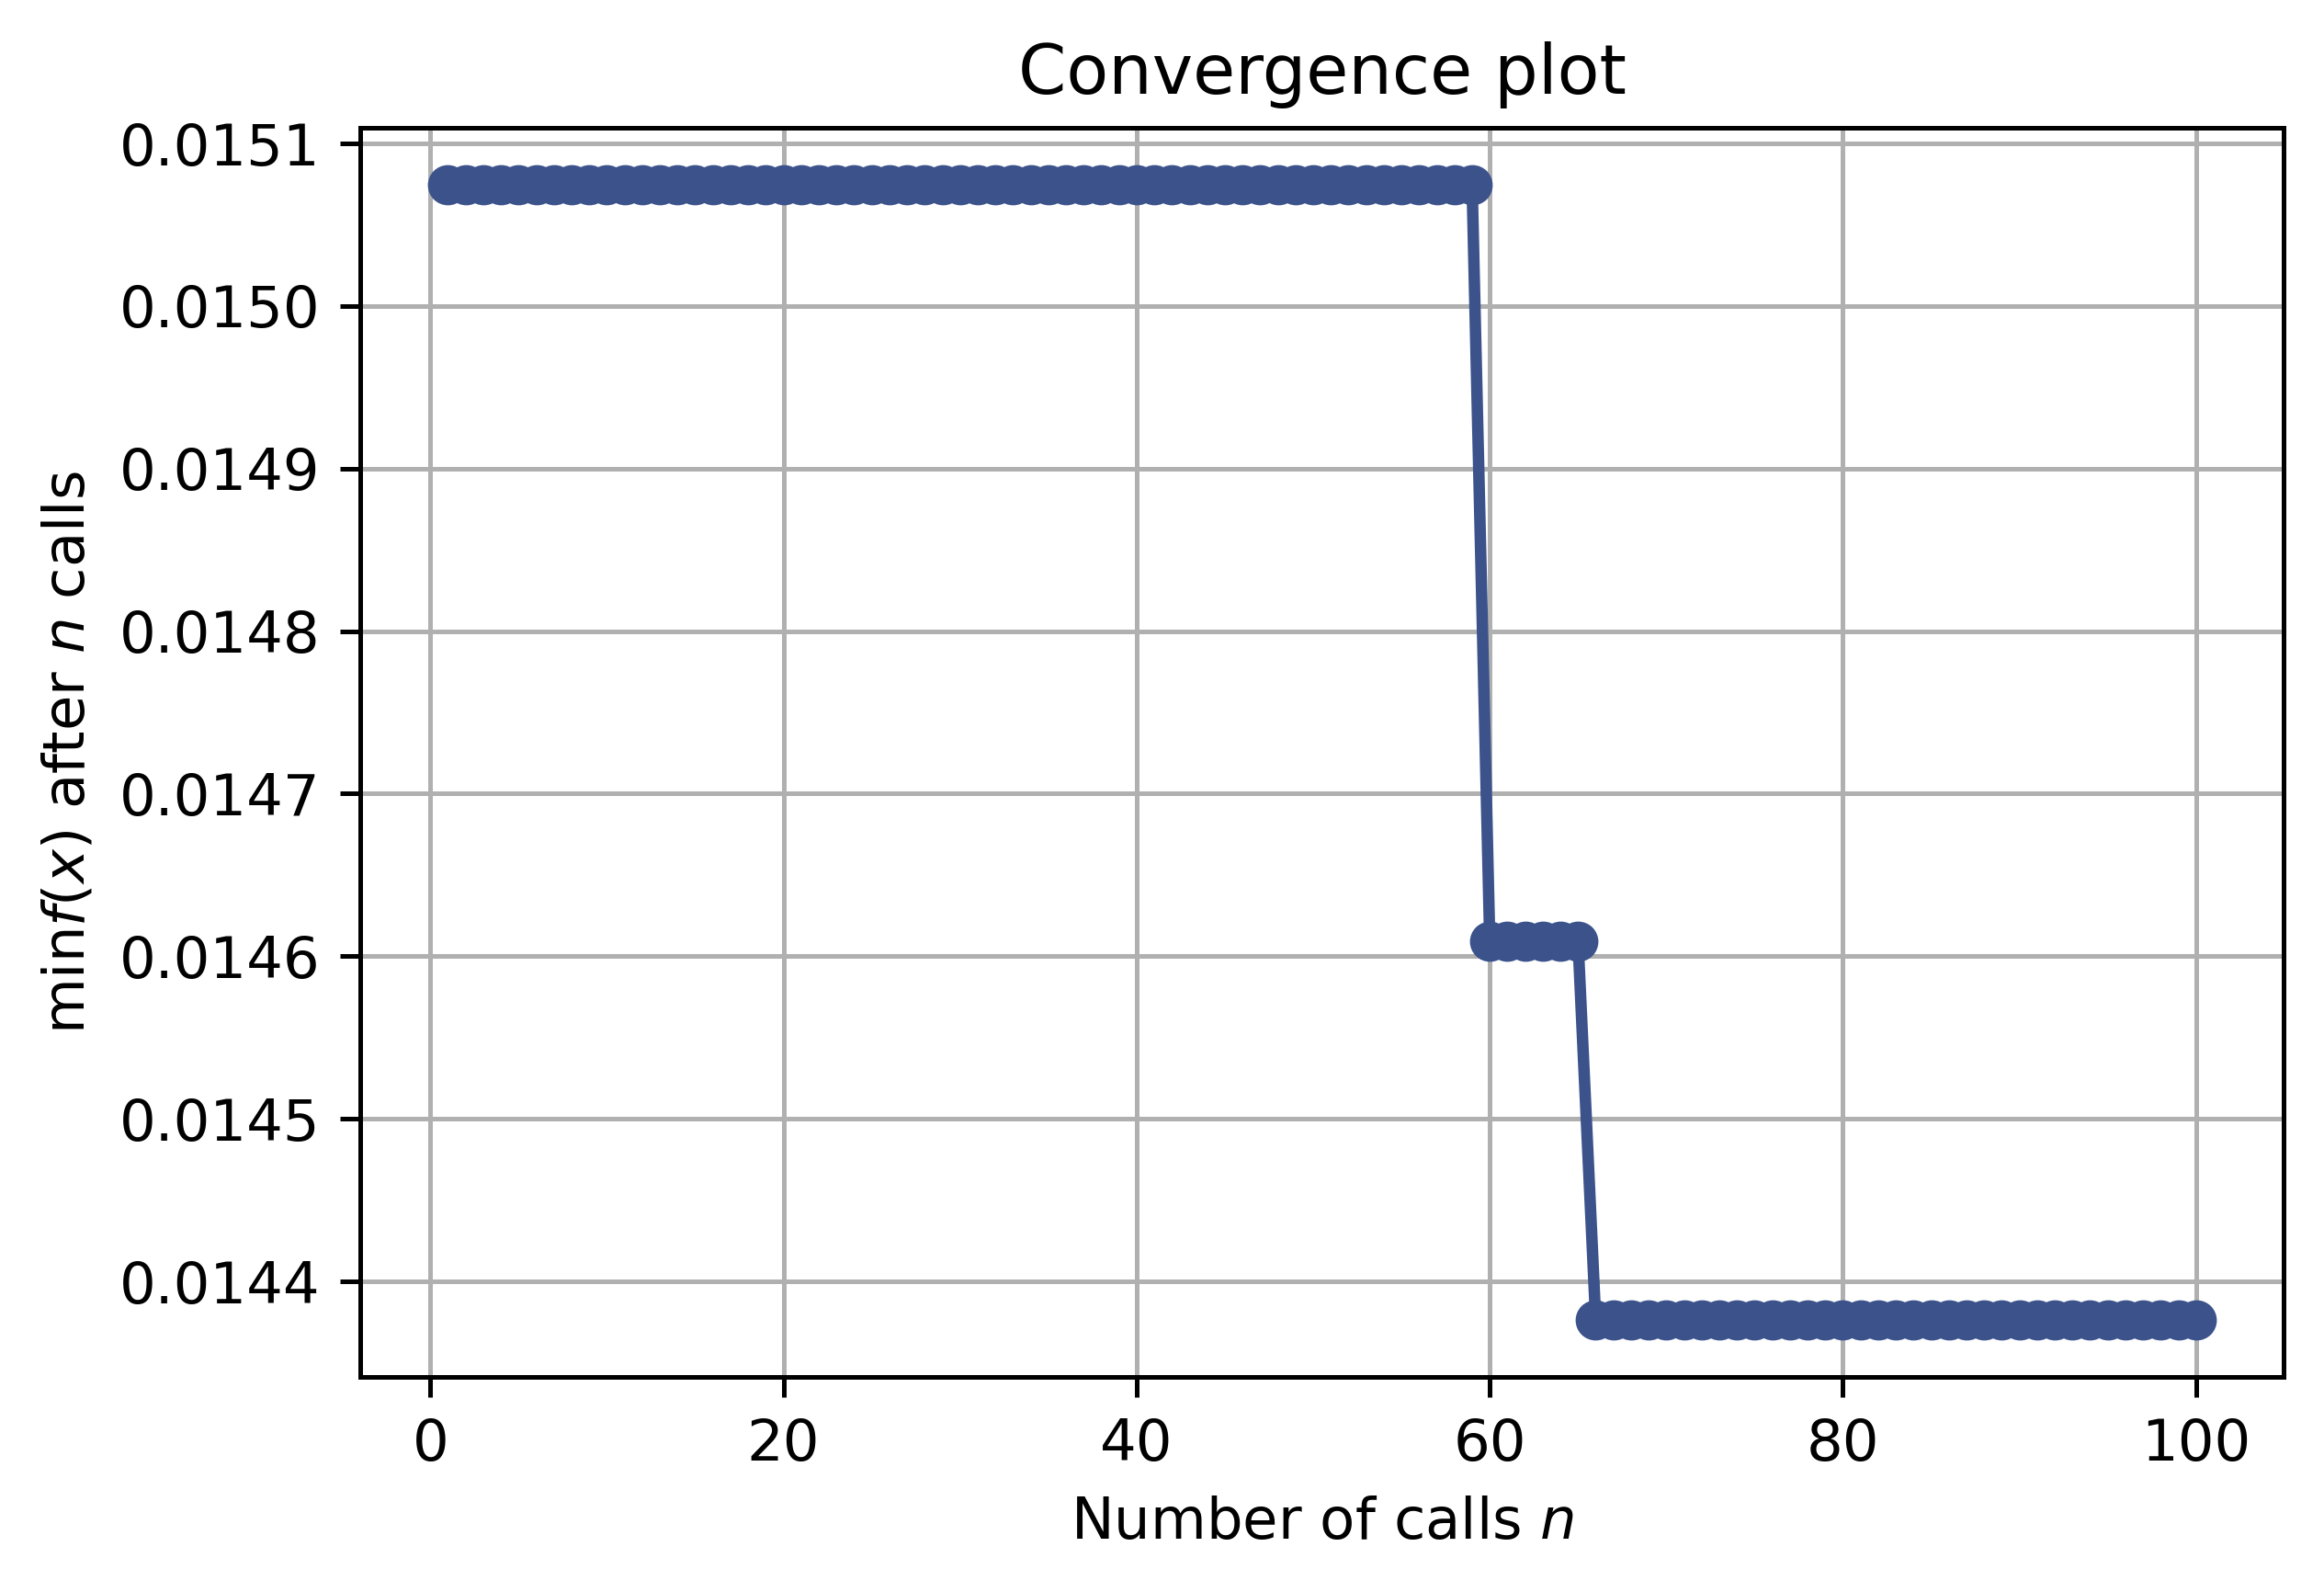

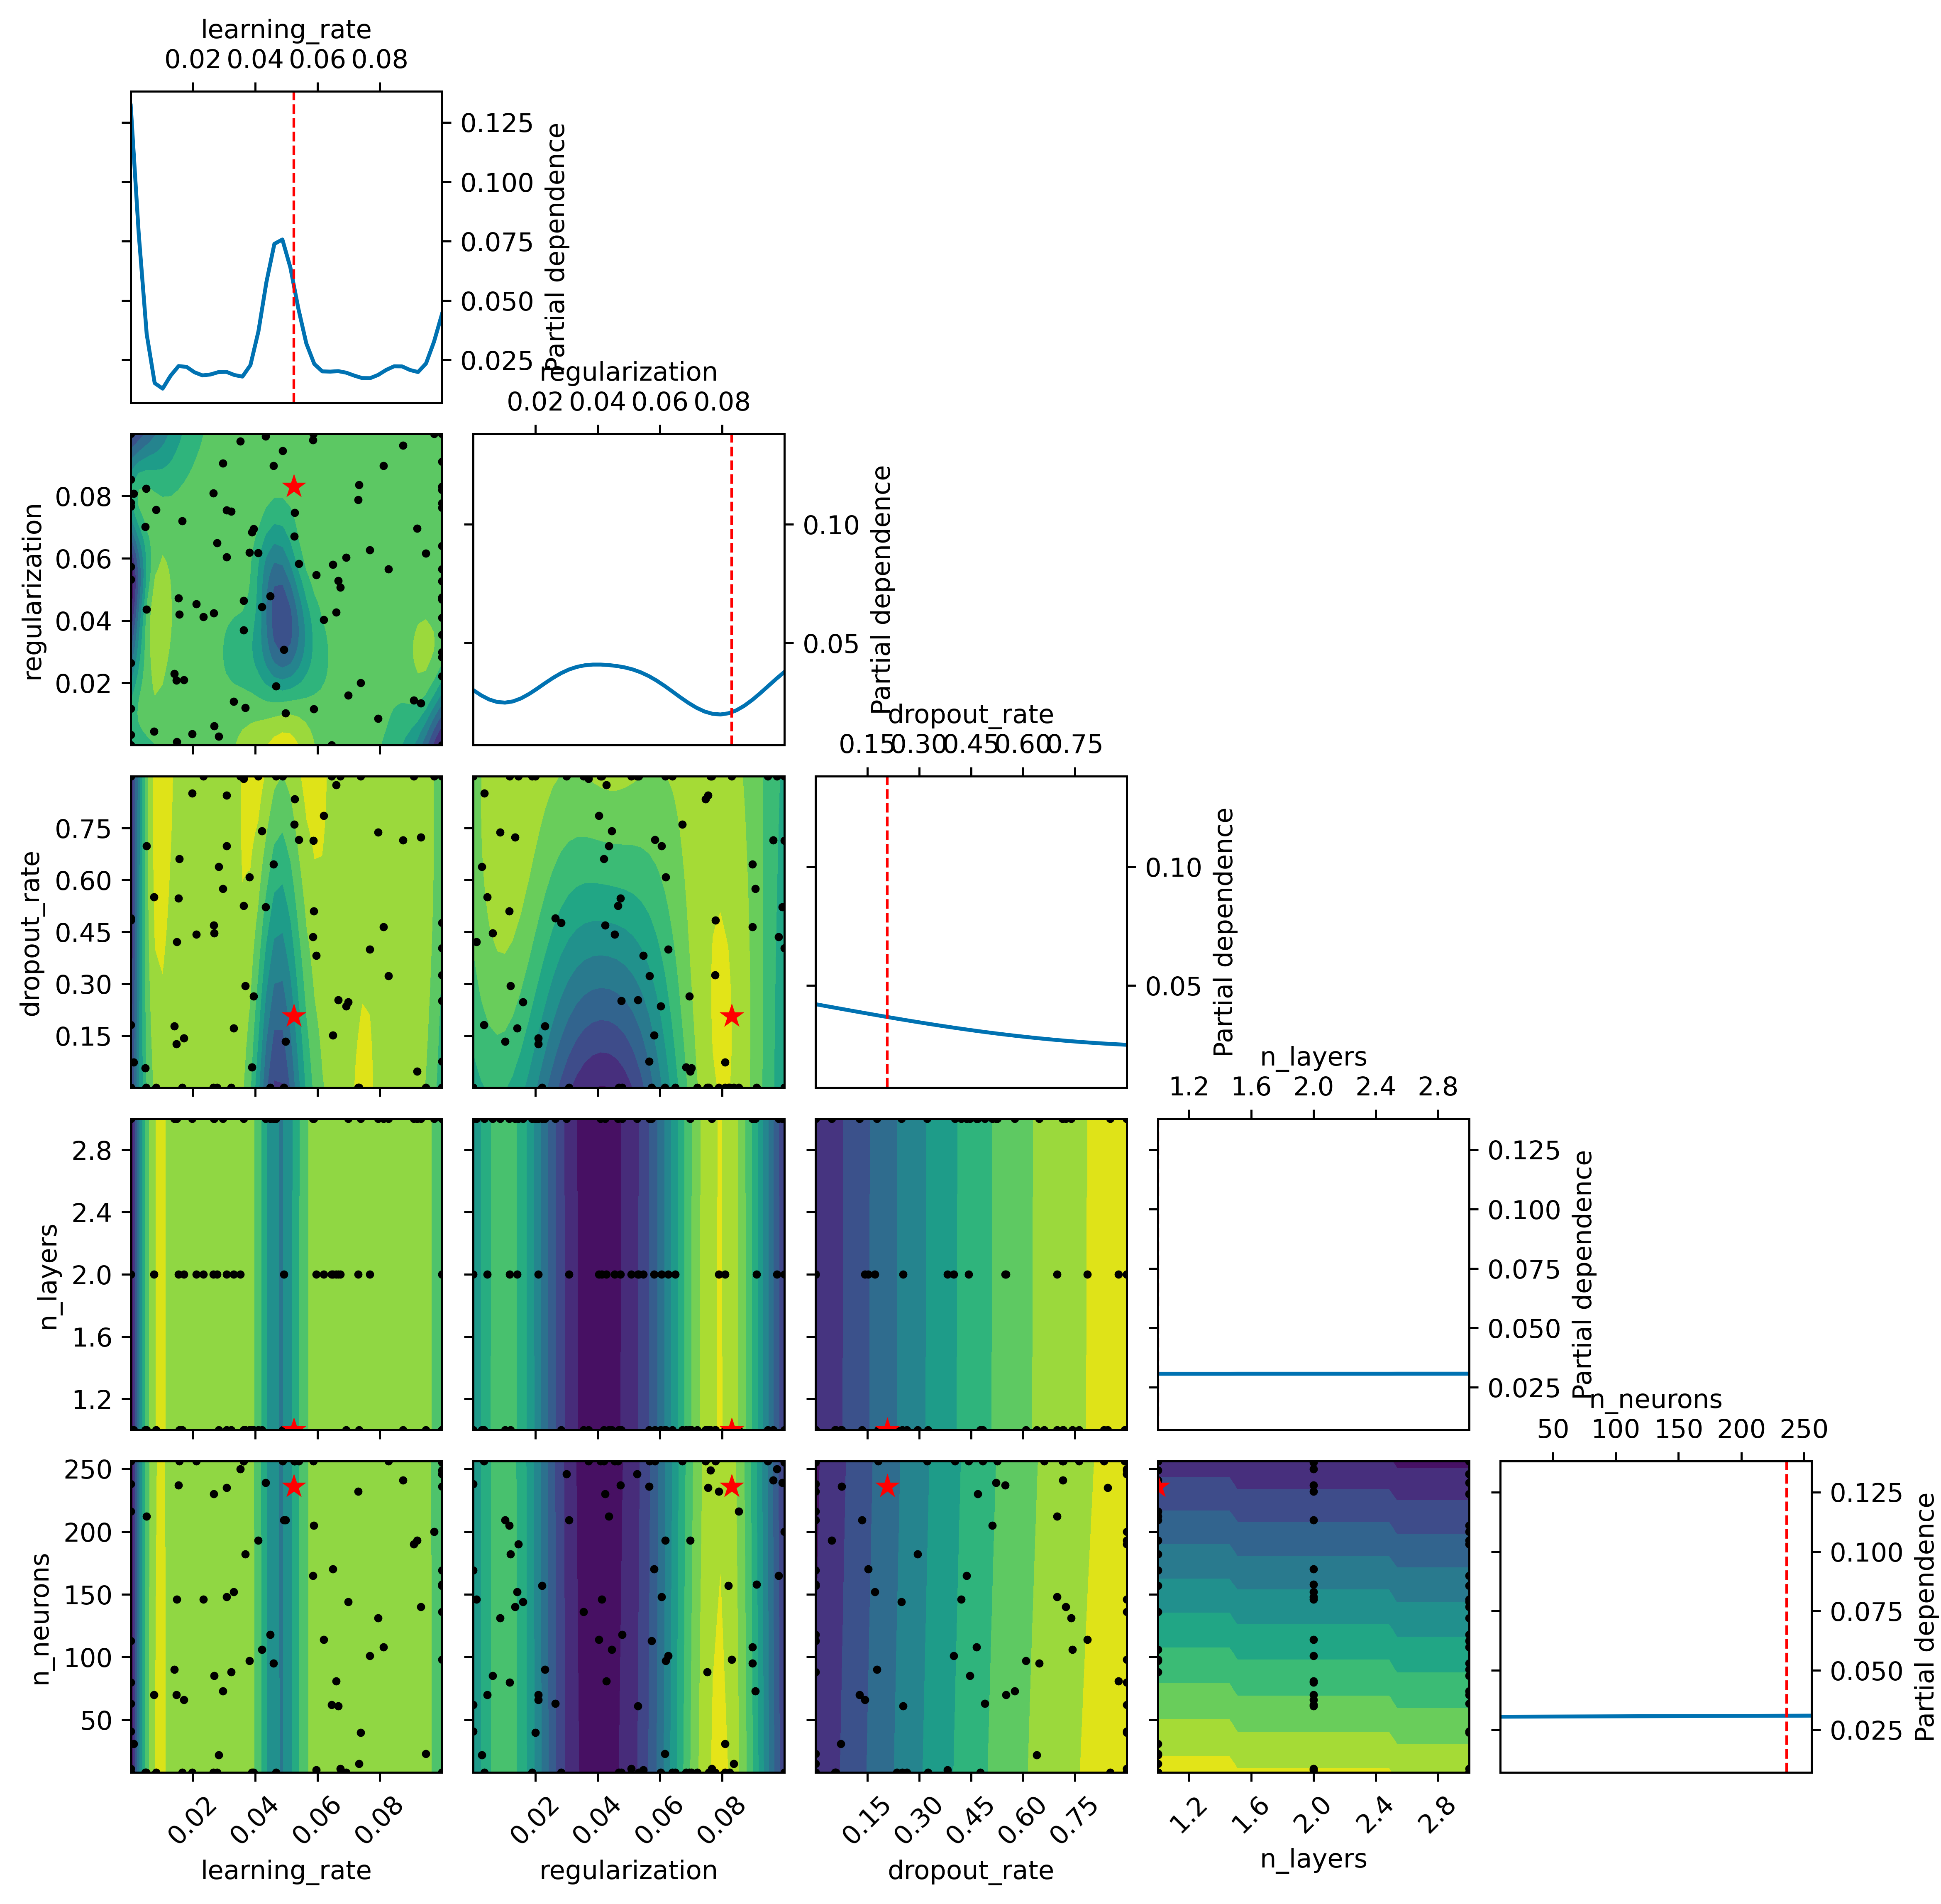

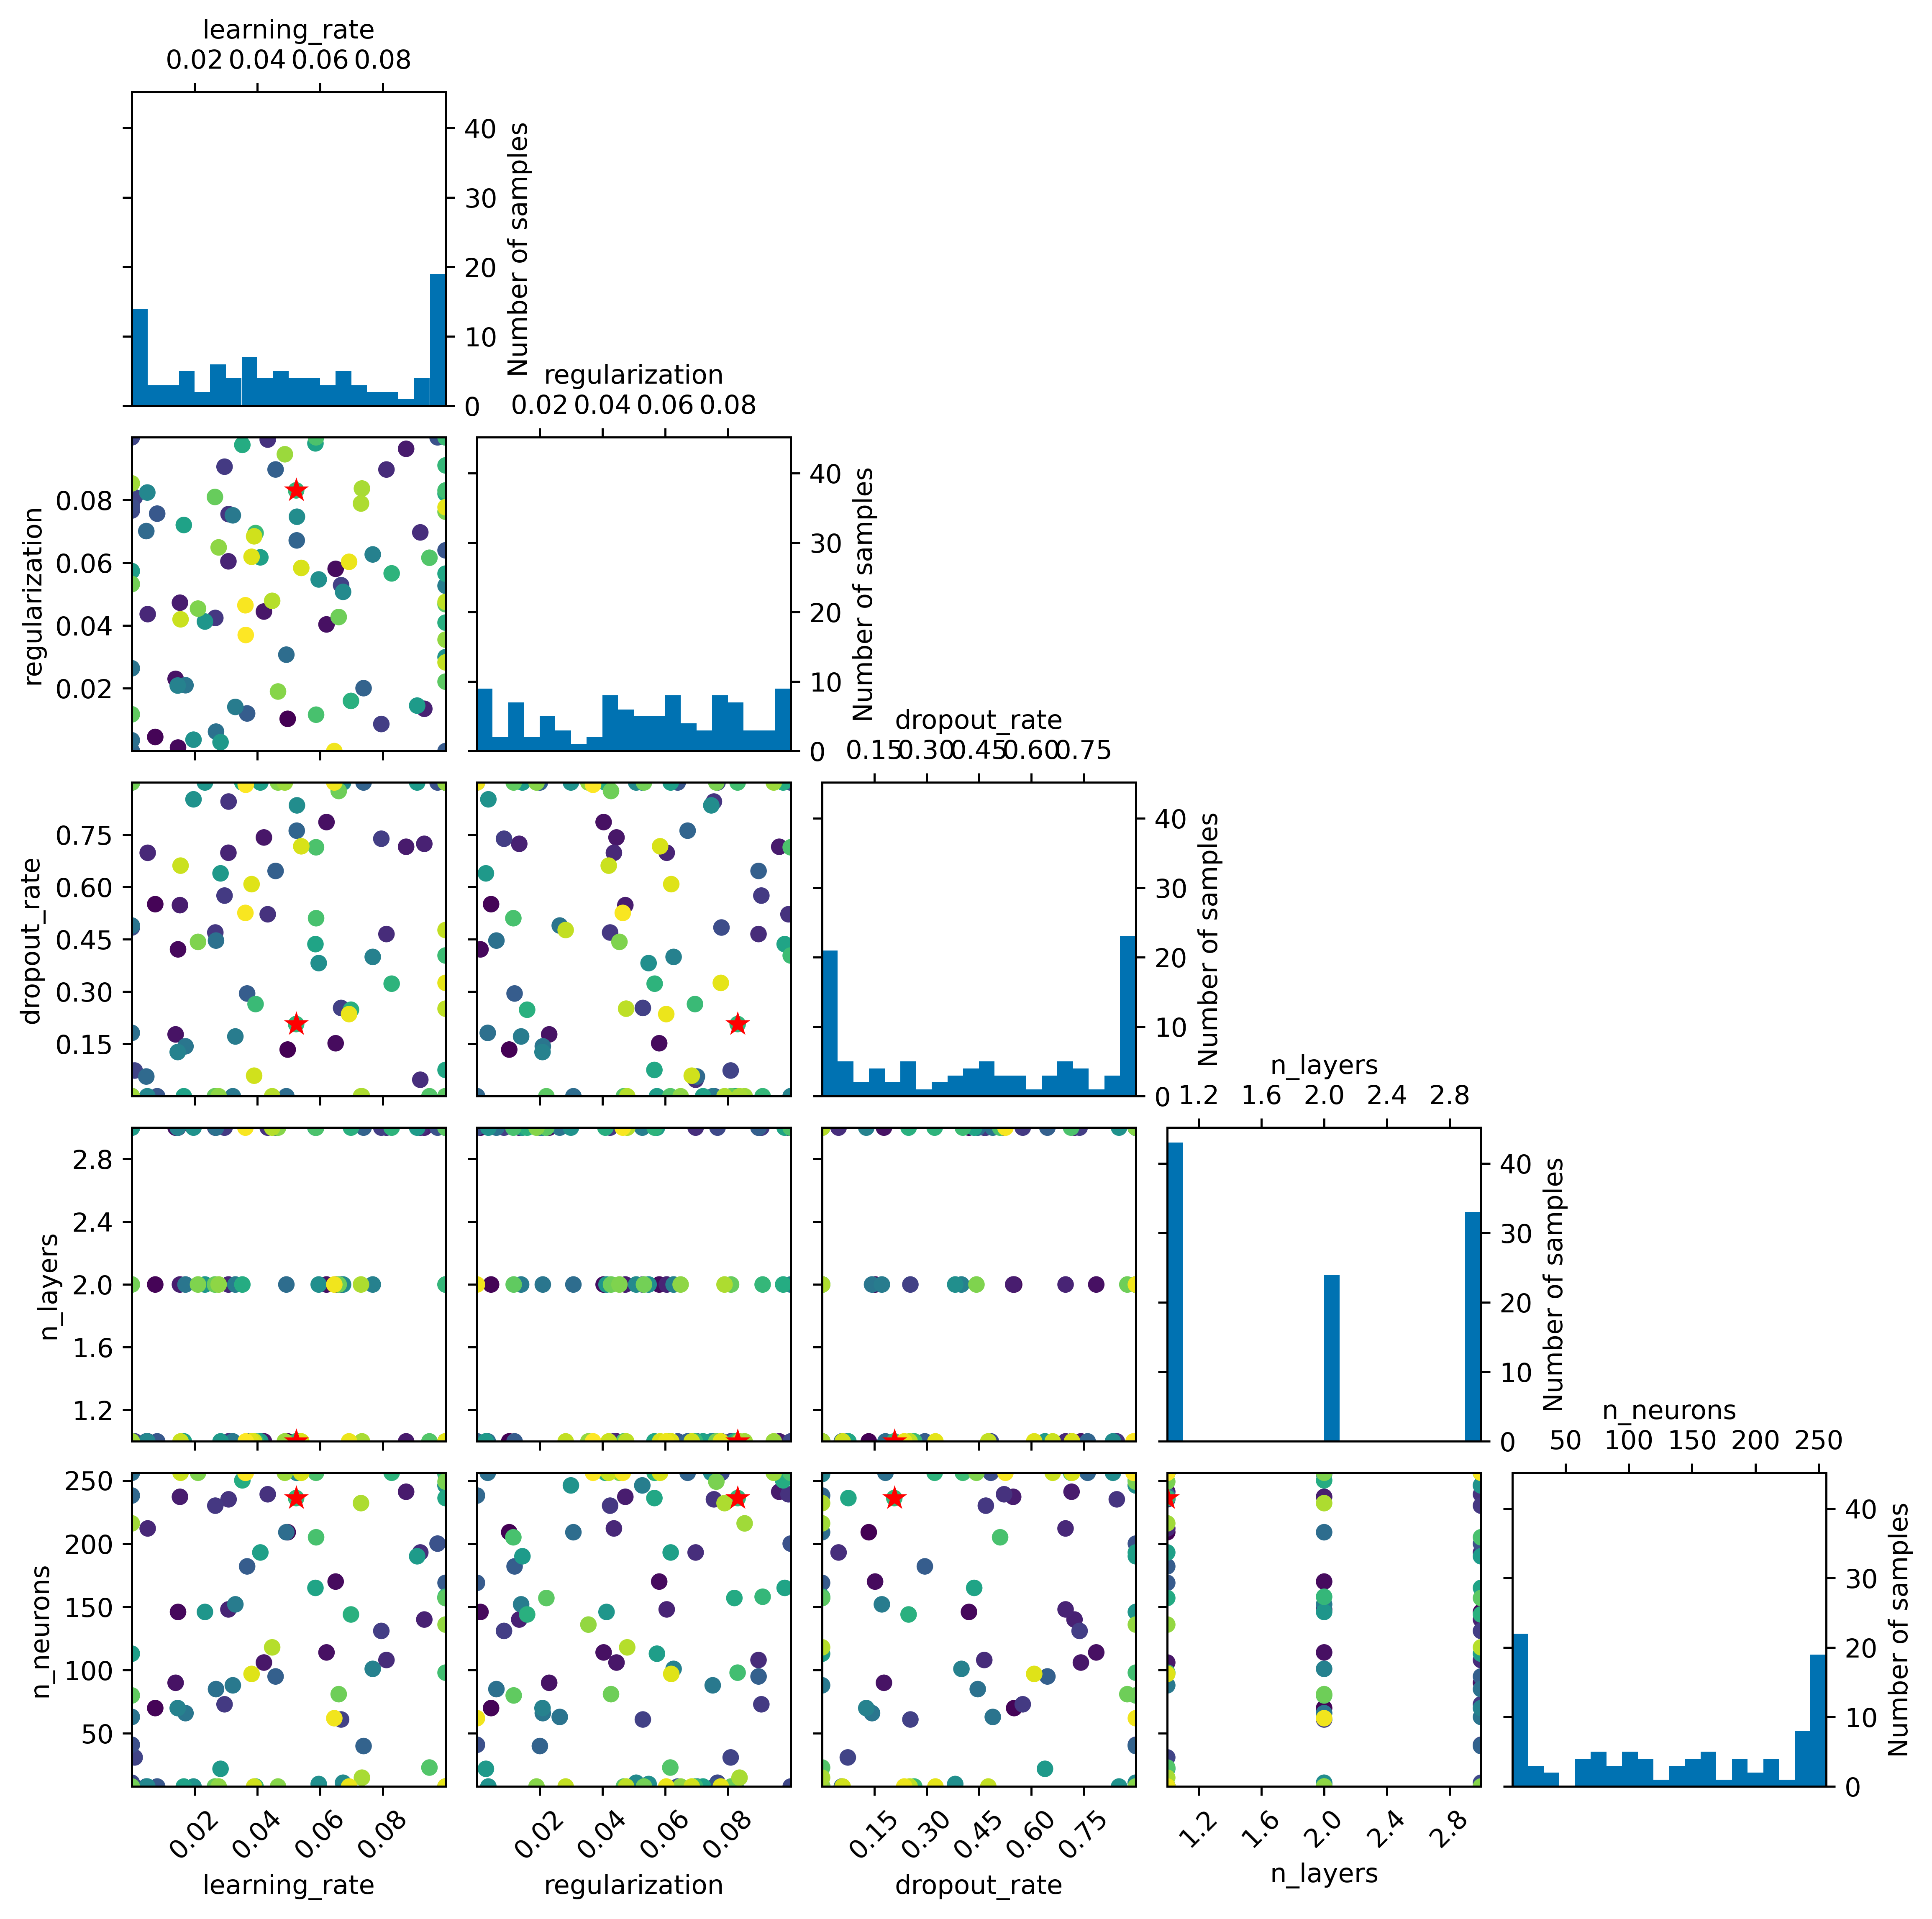

In [ ]:
# ------------------- Bayesian optimization --------------------------------- #


class tqdm_skopt(object):
    """Progress bar object for functions with callbacks."""

    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        """Update bar with intermediate results."""
        self._bar.update()


# Set parameter search space
# sourcery skip: merge-list-append
space = []
space.append(Real(1e-5, 1e-1, name="learning_rate"))
space.append(Real(1e-10, 1e-1, name="regularization"))
space.append(Integer(16, 128, name="conv1_channels"))
space.append(Integer(16, 128, name="conv2_channels"))
space.append(Integer(16, 128, name="linear1_neurons"))
space.append(Integer(16, 128, name="linear2_neurons"))

# Set default hyperparameters
default_params = [1e-3, 1e-5, 32, 64, 64, 32]

batch_size = 128
activation = nn.ReLU()

# Work in progress
@use_named_args(dimensions=space)
def fitness(learning_rate, regularization, conv1_channels, conv2_channels, linear1_neurons, linear2_neurons):
    """Perform Bayesian Hyperparameter tuning."""

    model = CNN(
        conv1_channels=conv1_channels,
        conv2_channels=conv2_channels,
        linear1_neurons=linear1_neurons,
        linear2_neurons=linear2_neurons,
    )
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=regularization)
    # Create k-fold cross validation
    avg_best_loss, *_ = kfold_cv_train(dataset=kfold_data, model=model, optimizer=optimizer, batch_size=batch_size)
    # print(f'Avg. best validation loss: {sum(best_losses)/n_splits}')

    return avg_best_loss


n_calls = 100
# Hyperparemeter search using Gaussian process minimization
gp_result = gp_minimize(
    func=fitness,
    x0=default_params,
    dimensions=space,
    n_calls=n_calls,
    random_state=SEED,
    verbose=True,
    callback=[tqdm_skopt(total=n_calls, desc="Gaussian Process")],
)

plot_convergence(gp_result)
plot_objective(gp_result)
plot_evaluations(gp_result)
gp_result.x